In [ ]:
pip install pandas numpy matplotlib yfinance scikit-learn torch


In [ ]:
import pandas as pd

# Load CSV
df = pd.read_csv("/content/Reliance.csv")

# Convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort data by time (VERY IMPORTANT)
df = df.sort_values('Date').reset_index(drop=True)

print(df.head())


        Date        Open        High         Low       Close   Adj Close  \
0 2015-11-18  463.799988  465.649994  454.975006  456.000000  436.671021   
1 2015-11-19  459.450012  469.350006  458.625000  467.375000  447.563873   
2 2015-11-20  467.000000  476.399994  462.774994  473.424988  453.357422   
3 2015-11-23  475.000000  478.950012  473.100006  476.875000  456.661224   
4 2015-11-24  476.500000  485.799988  475.524994  483.850006  463.340515   

      Volume  
0  5142766.0  
1  5569752.0  
2  5167930.0  
3  4800026.0  
4  6768886.0  


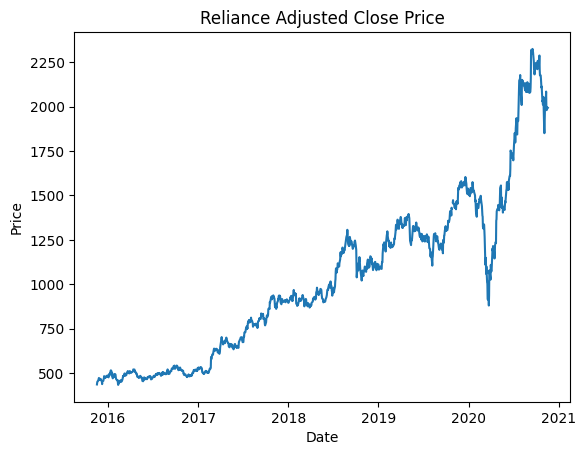

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df['Date'], df['Adj Close'])
plt.title("Reliance Adjusted Close Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


In [ ]:
# Daily return
df['Return'] = df['Adj Close'].pct_change()

# Moving averages (trend)
df['MA_5'] = df['Adj Close'].rolling(5).mean()
df['MA_20'] = df['Adj Close'].rolling(20).mean()

# Volatility (risk)
df['Volatility'] = df['Return'].rolling(20).std()

# Volume normalization
df['Volume_Change'] = df['Volume'].pct_change()

# Remove missing values
df = df.dropna()

print(df.head())


         Date        Open        High         Low       Close   Adj Close  \
20 2015-12-17  490.024994  507.500000  489.000000  504.850006  483.450378   
21 2015-12-18  501.899994  504.500000  495.000000  495.950012  474.927643   
22 2015-12-21  493.950012  499.500000  492.174988  496.049988  475.023376   
23 2015-12-22  496.399994  501.299988  492.000000  493.649994  472.725128   
24 2015-12-23  495.899994  503.450012  495.000000  501.899994  480.625427   

       Volume    Return        MA_5       MA_20  Volatility  Volume_Change  
20  8854870.0  0.031727  466.577240  460.990785    0.016974       0.601099  
21  7322040.0 -0.017629  470.307141  462.358974    0.017042      -0.173106  
22  5637670.0  0.000202  473.850311  463.442271    0.016893      -0.230041  
23  5293656.0 -0.004838  474.941992  464.245467    0.016928      -0.061021  
24  5906346.0  0.016712  477.350390  465.109712    0.017017       0.115740  


/tmp/ipython-input-1140575118.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Return'] = df['Adj Close'].pct_change()
/tmp/ipython-input-1140575118.py:12: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Volume_Change'] = df['Volume'].pct_change()


In [ ]:
# Target: 1 = price goes up tomorrow, 0 = down
df['Target'] = (df['Adj Close'].shift(-1) > df['Adj Close']).astype(int)

df = df.dropna()
print(df[['Adj Close', 'Target']].head())


     Adj Close  Target
20  483.450378       0
21  474.927643       1
22  475.023376       0
23  472.725128       1
24  480.625427       0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

features = ['Return', 'MA_5', 'MA_20', 'Volatility', 'Volume_Change']
X = df[features]
y = df['Target']

# Time-based split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

model = LogisticRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, predictions))


Accuracy: 0.4769874476987448


In [ ]:
df_test = df.iloc[len(X_train):].copy()
df_test['Prediction'] = predictions

# Strategy return
df_test['Strategy_Return'] = df_test['Prediction'] * df_test['Return']

# Cumulative performance
cumulative_return = (df_test['Strategy_Return'] + 1).prod() - 1
print("Strategy Return:", cumulative_return)


Strategy Return: -0.20961635959344205


In [ ]:
from sklearn.preprocessing import MinMaxScaler

features = ['Return', 'MA_5', 'MA_20', 'Volatility', 'Volume_Change']

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[features])


In [ ]:
import numpy as np

def create_sequences(X, y, window_size=10):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(scaled_features, df['Target'].values)
import numpy as np

def create_sequences(X, y, window_size=10):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(scaled_features, df['Target'].values)


In [ ]:
split = int(0.8 * len(X_seq))

X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]


In [ ]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return self.sigmoid(out)


In [ ]:
model = LSTMModel(input_size=X_train.shape[2], hidden_size=32)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

for epoch in range(10):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)

    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 0.6987
Epoch 2, Loss: 0.6980
Epoch 3, Loss: 0.6973
Epoch 4, Loss: 0.6966
Epoch 5, Loss: 0.6960
Epoch 6, Loss: 0.6954
Epoch 7, Loss: 0.6949
Epoch 8, Loss: 0.6944
Epoch 9, Loss: 0.6940
Epoch 10, Loss: 0.6936


In [ ]:
model.eval()

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

with torch.no_grad():
    probs = model(X_test_t)
    preds = (probs > 0.5).int()

accuracy = (preds == y_test_t.int()).float().mean()
print("LSTM Accuracy:", accuracy.item())


LSTM Accuracy: 0.5063291192054749


In [ ]:
df_lstm = df.iloc[-len(preds):].copy()
df_lstm['Prediction'] = preds.numpy()
df_lstm['Strategy_Return'] = df_lstm['Prediction'] * df_lstm['Return']

lstm_return = (df_lstm['Strategy_Return'] + 1).prod() - 1
print("LSTM Strategy Return:", lstm_return)


LSTM Strategy Return: 0.29008888176166137
